## Obspy Trigger Tests

The following IPython Notebook displays methods and tests performed in order to increase understanding with respect to obspy's trigger detection algorithms and functions. This done with the intention of creating a python program that can detect even small Mm Earthquakes and produce a file output with the information as to when these events occurred. One file output, formatted such that each line has one event activation time per station. For Example, if an event occurs and there are 8 stations in the network, the output should give 8 seperate start times event (that is if all stations have detected the event).

In [208]:
%matplotlib inline  
import obspy
import numpy as np
import matplotlib.pyplot as plt
from obspy import read 

Import test earthquake miniseed file. This is at a station named FJS on La Reunion Island. The file is located in the python working directory. In the stream plot output we can see what appear to be two potential earthquake events. From this, we expect the timing outputs to give times of approximately 2010-10-14T00:16:00.00000 and 2010-10-14T00:17:30.00000 respectively.

1 Trace(s) in Stream:
YA.FJS.00.HHZ | 2010-10-14T00:13:59.998299Z - 2010-10-14T00:17:59.998299Z | 100.0 Hz, 24001 samples


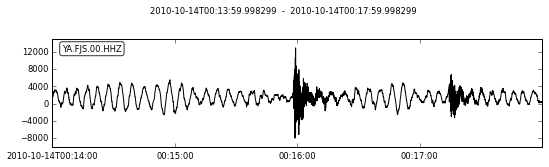

In [209]:
# set file name
fname = 'YA.FJS.00.HHZ.MSEED'

# import miniseed file as an obspy Stream object, st
st = read(fname)

# print and plot stream 
print(st)
st.plot()

tr = st[0]


Below we shall begin testing as many trigger functions in obspy.signal.trigger as possible. The triggerOnset() function appears to be the closest to what we are looking for.

The available functions are:


Function | Description
------------- | -------------
arPick  | Return corresponding picks of the AR picker
carlSTATrig   | Computes the carlSTATrig characteristic function
classicSTALTA | Computes the standard STA/LTA from a given input array a
classicSTALTAPy  | Return corresponding picks of the AR picker
coincidenceTrigger  | Perform a network coincidence trigger
delayedSTALTA  | Delayed STA/LTA
pkBaer | Wrapper for P-picker routine by M. Baer, Schweizer Erdbebendienst
plotTrigger  | Plot characteristic function of trigger
recSTALTA  | Recursive STA/LTA
recSTALTAPy  | Recursive STA/LTA written in Python
triggerOnset  | Calculate trigger on and off times
zDetect  | Z-detector


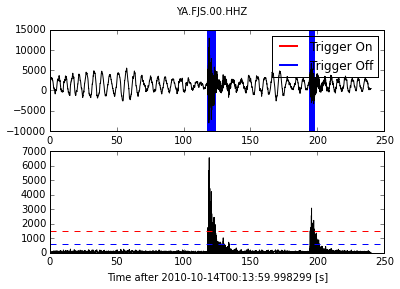

In [210]:
from obspy.signal.trigger import *

# give short term average (STA) and long term average (LTA) time windows as integers to be passed into other functions
STA_thres = 5
LTA_thres = 10

# input function sensitivity parameters, the smaller ratio and quiet are, 
# the more sensitive the characteristic function becomes
ratio = 0.001
quiet = 0.001

# first produce the STA/LTA characteristic function ctf associated with a given trace
ctf = abs(1-carlSTATrig(tr, STA_thres, LTA_thres, ratio, quiet))

# attempt classicSTALTA function to compute  STA/LTA for entire arrays
STA_LTA = classicSTALTA(tr, STA_thres, LTA_thres)

#define a trigger on threshold and a trigger off threshold

trig_on = 1500.0
trig_off = 600.0

# try now plotting the trigger functions using plotTrigger
plotTrigger(tr, ctf, trig_on, trig_off, show=True)


In [211]:
# now try triggerOnset function to calculate trigger on and off times for a given time frame

times = triggerOnset(ctf, trig_on, trig_off, max_len = 60.0)

# set times values to seconds
times = times / 100.0 

times = times[:,0]

# set events difference threshold

diff_thres = 30.0
event_times = []
event = []

for i in range(0, len(times) - 1):
    
    # check if two events in times array have a difference < diff_thres, if not, run average of those times, if so
    # append that events to a new events_times list
    time_diff = times[i + 1] - times[i]
        
    if time_diff > diff_thres:
        
        if len(event):    
        
            event_times.append(sum(event) / len(event))
            event = []
        
        event_times.append(times[i + 1])

    
    else:
        event.append(times[i])

start_time = tr.stats.starttime

UTC_events = []

for i in event_times:
    event = start_time + i
    UTC_events.append(event)
    print event
  

2010-10-14T00:16:00.427417Z
2010-10-14T00:17:14.618299Z


Now that we have a set of times that can accurately determine the triggered times of events and output that into a list called event_times, we are most of the way there to writting a program to automate this function for us. What is needed now is another test on a series of multiple events to see how accurate this function behaves.

In [212]:
# firstly combine everything above into one function. The inputs of this function will be 
#the traces and the outputs the event times

from obspy.signal.trigger import *

def UTC_times(times, 
              trace, 
              diff_thres = 30.0):
    
    """
    Function that takes the output of the obspy.signal.trigger function triggerOnset() and computes
    an average for points that do no differ by a certain difference threshold (diff_thres), and gives 
    back any individual points that differ by more than this threshold on either side.
    
    Finally the function converts this output into seconds and then adds those on to the starting time
    of the trace 
    """
    
    # set times values to seconds
    times = times / 100.0 
    
    #remove unwanted parts of times numpy array 
    times = times[:,0]
    
    event_times = []
    event = []
    
    for i in range(0, len(times) - 1):
    
        # check if two events in times array have a difference < diff_thres, 
        #if not, run average of those times, if so append that events to a 
        #new events_times list
        
        time_diff = times[i + 1] - times[i]
        
        if time_diff > diff_thres:
        
            if len(event):    
        
                event_times.append(sum(event) / len(event))
                event = []
        
            event_times.append(times[i + 1])

    
        else:
            event.append(times[i])
            
            

    start_time = trace.stats.starttime

    UTC_events = []

    for i in event_times:
        event = start_time + i
        UTC_events.append(event)
        
    return UTC_events


def trigger_times(trace, 
                  STA        = 5, 
                  LTA        = 10, 
                  ratio      = 0.001,
                  quiet      = 0.001,           
                  trig_on    = 1500.0,
                  trig_off   = 600.0,
                  DIFF_THRES = 30.0,
                  show       = False):
    
    """
    Function that returns UTCdatetime objects of events from a given input trace. It uses carlSTATrig to 
    find the characteristic function of the trace, then plots the trigger findings using the plotTrigger and finally
    the function UTC_events is used to compute the event timings in UTC format from the ouput of the function
    triggerOnset.
    
    Input parameters are:
    
    trace      - must be an obspy Trace object.
    STA        - must be an int object which defines the short term average time window in seconds.
    LTA        - must be an int object which defines the long term average time window in seconds.
    ratio      - must be a float object, the lower the ratio number, the more sensitive the 
                 characteristic function's output.
    quiet      - must be a float object, the lower the quiet number, the more sensitive the 
                 characteristic function's output.
    DIFF_THRES - must be a float object which defines the minimum window difference between successive events. 
                 this is then used by the UTC_times function in order to determine whether a times output
                 is within a singular event or it differs enough to be called a seperate event. 

    """
    

    # first produce the STA/LTA characteristic function ctf associated with a given trace
    ctf = abs(1-carlSTATrig(tr, STA, LTA, ratio, quiet))

    if show == True:
        # use plotting the trigger functions using plotTrigger
        plotTrigger(tr, ctf, trig_on, trig_off, show=True) 
    
    
    # use triggerOnset function to calculate trigger on and off times for a given time frame
    times = triggerOnset(ctf, trig_on, trig_off, max_len = 60.0)
    
    if len(times) >= 1:

        UTC_events = UTC_times(times, trace = tr, diff_thres = DIFF_THRES)
    
        return UTC_events

trigger_times(tr)

[2010-10-14T00:16:00.427417Z, 2010-10-14T00:17:14.618299Z]

Now we can use the functions defined above to automate this process for many different miniseed files.

In [214]:
import glob

# define a folder with many miniseed files in it

folder_name = './trigger_miniseeds'

# get a list of all miniseed files within the directory above

file_list = glob.glob('{}/*.MSEED'.format(folder_name))


all_events = []
for f in file_list:
    # import miniseed file as an obspy Stream object, st
    st = read(f)
    # print and plot stream
    #print(st)
    #st.plot()

    tr = st[0]

    UTC_events = trigger_times(tr)

    if UTC_events != None and len(UTC_events) >= 1: 
        for event in UTC_events:
        
            event_list = [tr.stats.network, tr.stats.station, event]
            all_events.append(event_list)

for i in all_events: 
    event_string = '{} - {} - {}'.format(i[0], i[1], i[2])
    print event_string

YA - SNE - 2010-10-14T00:15:58.128300Z
YA - SNE - 2010-10-14T00:16:00.390919Z
YA - SNE - 2010-10-14T00:17:14.508300Z
YA - UV12 - 2010-10-14T00:16:00.596364Z
YA - UV12 - 2010-10-14T00:17:15.080000Z
YA - UV15 - 2010-10-14T00:16:00.296250Z
YA - UV15 - 2010-10-14T00:17:14.300000Z
YA - UV08 - 2010-10-14T00:15:59.380000Z
YA - UV08 - 2010-10-14T00:17:15.660000Z
YA - UV07 - 2010-10-14T00:15:58.320000Z
YA - UV07 - 2010-10-14T00:15:59.120000Z
YA - UV07 - 2010-10-14T00:17:15.430000Z
YA - UV11 - 2010-10-14T00:15:57.930000Z
YA - UV11 - 2010-10-14T00:15:59.430385Z
YA - UV11 - 2010-10-14T00:17:14.310000Z
YA - UV05 - 2010-10-14T00:15:58.030000Z
YA - UV05 - 2010-10-14T00:16:01.182353Z
YA - UV05 - 2010-10-14T00:17:14.410000Z
YA - RVL - 2010-10-14T00:15:59.574013Z
YA - RVL - 2010-10-14T00:17:14.488299Z
YA - UV10 - 2010-10-14T00:15:58.810000Z
YA - FLR - 2010-10-14T00:16:00.679550Z
YA - FLR - 2010-10-14T00:17:14.928300Z
YA - FJS - 2010-10-14T00:16:00.427417Z
YA - FJS - 2010-10-14T00:17:14.618299Z
